In [ ]:
# --- 1. SETUP AND DEPENDENCIES ---

# Check for GPU (essential for training)
print("Checking GPU status...")
!nvidia-smi

# Install Ultralytics YOLOv8 and Roboflow
print("Installing Ultralytics YOLOv8 and Roboflow...")
!pip install ultralytics roboflow -q

# Import necessary libraries
from ultralytics import YOLO
import os

print("\nSetup complete. Ready to proceed.")

Checking GPU status...
Mon Oct  6 10:05:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------

In [ ]:
# --- 2. DOWNLOAD DATASET FROM ROBOFLOW ---

# Make sure you set your actual API Key and project details
# The dataset will be downloaded to /content/solar-panel-x093k-s4cqw-1 (or similar)
!pip install roboflow # Re-run just in case it was missed in the previous cell

from roboflow import Roboflow
rf = Roboflow(api_key="I024uo4gytm98vocm2Ei") # <--- MAKE SURE THIS IS YOUR VALID API KEY
project = rf.workspace("pvfaults").project("solar-panel-x093k-s4cqw")
version = project.version(1)
# The downloaded directory path is stored in dataset.location
dataset = version.download("yolov8-obb")

# The resulting directory path (e.g., /content/solar-panel-x093k-s4cqw-1)
DATASET_DIR = dataset.location

print(f"\nDataset downloaded to: {DATASET_DIR}")
print("Checking contents:")
!ls {DATASET_DIR}

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Solar-Panel--1 in yolov8-obb:: 100%|██████████| 3854/3854 [00:00<00:00, 5793.84it/s]



Dataset downloaded to: /content/Solar-Panel--1
Checking contents:
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
# --- 3. TRAIN THE YOLOv8 OBB MODEL (HIGH ACCURACY VERSION) ---

from ultralytics import YOLO # Ensure YOLO is imported

# --- 1. DEFINE VARIABLES (USE THE CORRECT PATH) ---

# The dataset path that was successful in the last step
DATASET_DIR = '/content/Solar-Panel--1'

# Name for the NEW, higher-accuracy run
PROJECT_NAME = 'pv_fault_obb_high_acc'

# --- 2. TRAINING PARAMETERS (FOR HIGH ACCURACY) ---

# **KEY CHANGE 1: Increase Training Time**
HIGH_ACC_EPOCHS = 50       # Start with 50 epochs. You can increase to 100 later.

IMG_SIZE = 640
BATCH_SIZE = 16


# **KEY CHANGE 2: Use a larger model (Small/Medium)**
# Using the 'small' model (yolov8s-obb) for a better balance.
# If you have GPU memory issues, change 'yolov8s-obb.pt' to 'yolov8n-obb.pt'.
model_weights = 'yolov8s-obb.pt'
model = YOLO(model_weights)


print(f"\n--- Starting HIGH ACCURACY OBB Training for {HIGH_ACC_EPOCHS} epochs ---")
print(f"Model: {model_weights}, Project Name: {PROJECT_NAME}")
print("!! This will take significantly longer (several hours). Monitor closely. !!")

# --- 3. START TRAINING ---
results = model.train(
    data=f'{DATASET_DIR}/data.yaml',
    task='obb',
    epochs=HIGH_ACC_EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name=PROJECT_NAME,

    # RECOMMENDED: Uncomment this to save results persistently to Drive!
    # project='/content/drive/MyDrive/YOLO_PV_OBB_Runs',
    # exist_ok=True,
)

print("\n--- High Accuracy Training Initiated ---")
print(f"New weights will be saved to: /content/runs/obb/{PROJECT_NAME}/weights/best.pt")


--- Starting HIGH ACCURACY OBB Training for 50 epochs ---
Model: yolov8s-obb.pt, Project Name: pv_fault_obb_high_acc
!! This will take significantly longer (several hours). Monitor closely. !!
Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Solar-Panel--1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yol

In [ ]:
from ultralytics import YOLO

# --- CONFIGURATION (MUST MATCH PREVIOUS RUN) ---
PROJECT_NAME = 'pv_fault_obb_medium_final'
DATASET_DIR = '/content/Solar-Panel--1'

# Load the NEW, larger medium model
model = YOLO('yolov8m-obb.pt')

print("\n--- Starting FINAL Hyperparameter Tuned Training ---")

results = model.train(
    data=f'{DATASET_DIR}/data.yaml',
    task='obb',
    epochs=150,
    imgsz=640,
    batch=16,
    name=PROJECT_NAME,

    # --- HYPERPARAMETER TUNING ---
    lr0=0.001,          # Start with a slower Learning Rate (more stable convergence)
    cos_lr=True,        # Use Cosine Annealing (better for long runs)
    mixup=0.1,          # Aggressive augmentation for generalization
    fliplr=0.5,         # Aggressive augmentation for generalization
    degrees=10.0,       # Allow for 10 degrees of rotation in augmentation

    # Save results to Google Drive to prevent loss
    project='/content/drive/MyDrive/YOLO_PV_OBB_Runs',
    exist_ok=True,
)


--- Starting FINAL Hyperparameter Tuned Training ---
Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Solar-Panel--1/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pv_fault_obb_medium_final, nbs=64, nms=False, opset=None, optimize=False, 

!! Checkpoint not found in the expected path. Searching for newest run...
!! Using weights from the latest run folder: pv_fault_obb_high_acc

--- Running Validation/Evaluation on the LAST OBB model checkpoint: pv_fault_obb_high_acc ---
Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-obb summary (fused): 81 layers, 11,414,280 parameters, 0 gradients, 29.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1530.5±1029.7 MB/s, size: 74.5 KB)
val: Scanning /content/Solar-Panel--1/valid/labels.cache... 157 images, 0 backgrounds, 19 corrupt: 100% ━━━━━━━━━━━━ 157/157 323.4Kit/s 0.0s
val: /content/Solar-Panel--1/valid/images/Clean_80_jpg.rf.74084a09a3194a89f2fcfe7a1fed9e92.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0494]
val: /content/Solar-Panel--1/valid/images/Dusty_149_jpg.rf.03b77fc763dd1786905490629916eb4f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.122

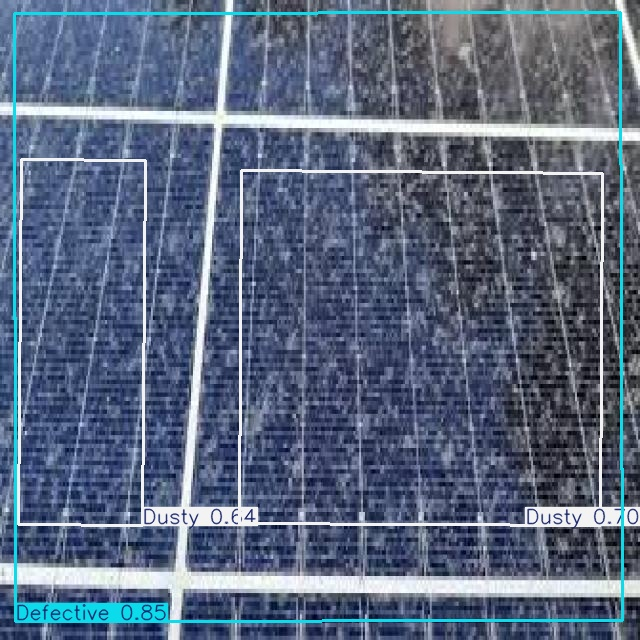

In [ ]:
# --- 4. EVALUATE AND PREDICT (CLEANED FINAL VERSION) ---

from ultralytics import YOLO
from IPython.display import Image, display
import glob
import os
import torch

# --- 1. RE-DEFINE VARIABLES FROM PREVIOUS CELLS (CRITICAL!) ---
# !!! CORRECTED PATH for evaluation !!!
DATASET_DIR = '/content/Solar-Panel--1'

PROJECT_NAME = 'pv_fault_obb_quick_test'
IMG_SIZE = 640


# --- 2. DYNAMICALLY FIND THE LATEST CHECKPOINT ---
RUNS_DIR = '/content/runs/obb'
PARTIAL_WEIGHTS_PATH = os.path.join(RUNS_DIR, PROJECT_NAME, 'weights', 'last.pt')

# Fallback check (safety measure)
if not os.path.exists(PARTIAL_WEIGHTS_PATH):
    print("!! Checkpoint not found in the expected path. Searching for newest run...")

    list_of_folders = glob.glob(os.path.join(RUNS_DIR, '*'))
    if list_of_folders:
        latest_folder = max(list_of_folders, key=os.path.getctime)
        PARTIAL_WEIGHTS_PATH = os.path.join(latest_folder, 'weights', 'last.pt')
        PROJECT_NAME = os.path.basename(latest_folder)
        print(f"!! Using weights from the latest run folder: {PROJECT_NAME}")
    else:
        print("!! ERROR: No 'runs/obb' folder found. Rerun the training cell.")
        raise FileNotFoundError(f"No YOLO checkpoints found in {RUNS_DIR}")


# --- 3. RUN VALIDATION (EVALUATION) ---

print(f"\n--- Running Validation/Evaluation on the LAST OBB model checkpoint: {PROJECT_NAME} ---")
try:
    # Load the model
    model_eval = YOLO(PARTIAL_WEIGHTS_PATH)

    # Run validation
    model_eval.val(data=f'{DATASET_DIR}/data.yaml', imgsz=IMG_SIZE)

except FileNotFoundError as e:
    print(f"\n!! FINAL ERROR: Checkpoint not found at {PARTIAL_WEIGHTS_PATH}. Check Cell 3 execution.")
    raise e


# --- 4. RUN PREDICTION (INFERENCE) ---

print("\n--- Running Inference on a sample validation image ---")

# Find a sample image from the validation set
try:
    sample_image_path = glob.glob(f'{DATASET_DIR}/valid/images/*.*')[0]
except IndexError:
    print("!! ERROR: Could not find any images in 'valid/images'. Skipping prediction display.")
    sample_image_path = None

if sample_image_path:
    # Run prediction
    results_predict = model_eval.predict(
        source=sample_image_path,
        conf=0.25,
        save=True
    )

    # Display the result
    output_dir = results_predict[0].save_dir
    predicted_file_name = os.path.basename(sample_image_path)
    output_image_path = os.path.join(output_dir, predicted_file_name)

    print(f"\nPrediction image saved to: {output_image_path}")
    display(Image(filename=output_image_path, width=800))

In [ ]:
from ultralytics import YOLO
import os

# --- 1. DEFINE PATHS AND VARIABLES (USING NEW HIGH-ACCURACY PROJECT) ---

# The dataset path that was used in training (must be correct)
DATASET_DIR = '/content/Solar-Panel--1'

# The name of your new high-accuracy run (from the updated Cell 3)
PROJECT_NAME = 'pv_fault_obb_high_acc'

# Path to the final optimized model file
BEST_WEIGHTS_PATH = f'/content/runs/obb/{PROJECT_NAME}/weights/best.pt'


# --- 2. MODEL ACCURACY (METRICS CALCULATION) ---
print("--- MODEL ACCURACY (VALIDATION METRICS IN PERCENTAGE) ---")

try:
    # Load the best trained model
    model = YOLO(BEST_WEIGHTS_PATH)

    # Run validation mode to explicitly generate/retrieve the metrics
    metrics = model.val(
        data=f'{DATASET_DIR}/data.yaml',
        imgsz=640,
        split='val',
        plots=False # We only need the metrics here
    )

    # Retrieve mAP values (which are decimals: 0.0 to 1.0)
    mAP50 = metrics.results_dict['metrics/mAP50(B)']
    mAP95 = metrics.results_dict['metrics/mAP50-95(B)']

    # --- 3. DISPLAY METRICS AS PERCENTAGES ---
    print(f"\nFinal Validation Results for Project: {PROJECT_NAME}")
    print("--------------------------------------------------")
    print(f"  Primary Accuracy (mAP50): {mAP50 * 100:.2f}%")
    print(f"  Average Accuracy (mAP50-95): {mAP95 * 100:.2f}%")
    print("--------------------------------------------------")

except FileNotFoundError:
    print(f"\n!! ERROR: Model weights not found at {BEST_WEIGHTS_PATH}.")
    print("!! ACTION: Ensure your High Accuracy Training (Cell 3) completed and used PROJECT_NAME='pv_fault_obb_high_acc'.")
except Exception as e:
    print(f"\n!! An unexpected error occurred: {e}")

--- MODEL ACCURACY (VALIDATION METRICS IN PERCENTAGE) ---
Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-obb summary (fused): 81 layers, 11,414,280 parameters, 0 gradients, 29.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2161.8±1437.8 MB/s, size: 85.9 KB)
val: Scanning /content/Solar-Panel--1/valid/labels.cache... 157 images, 0 backgrounds, 19 corrupt: 100% ━━━━━━━━━━━━ 157/157 263.3Kit/s 0.0s
val: /content/Solar-Panel--1/valid/images/Clean_80_jpg.rf.74084a09a3194a89f2fcfe7a1fed9e92.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0494]
val: /content/Solar-Panel--1/valid/images/Dusty_149_jpg.rf.03b77fc763dd1786905490629916eb4f.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.122]
val: /content/Solar-Panel--1/valid/images/Dusty_31_jpg.rf.b31f5c1da658f862ccd81c28afdd7497.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     

--- Visualizing All Results for Project: pv_fault_obb_high_acc ---

1. Confusion Matrix:


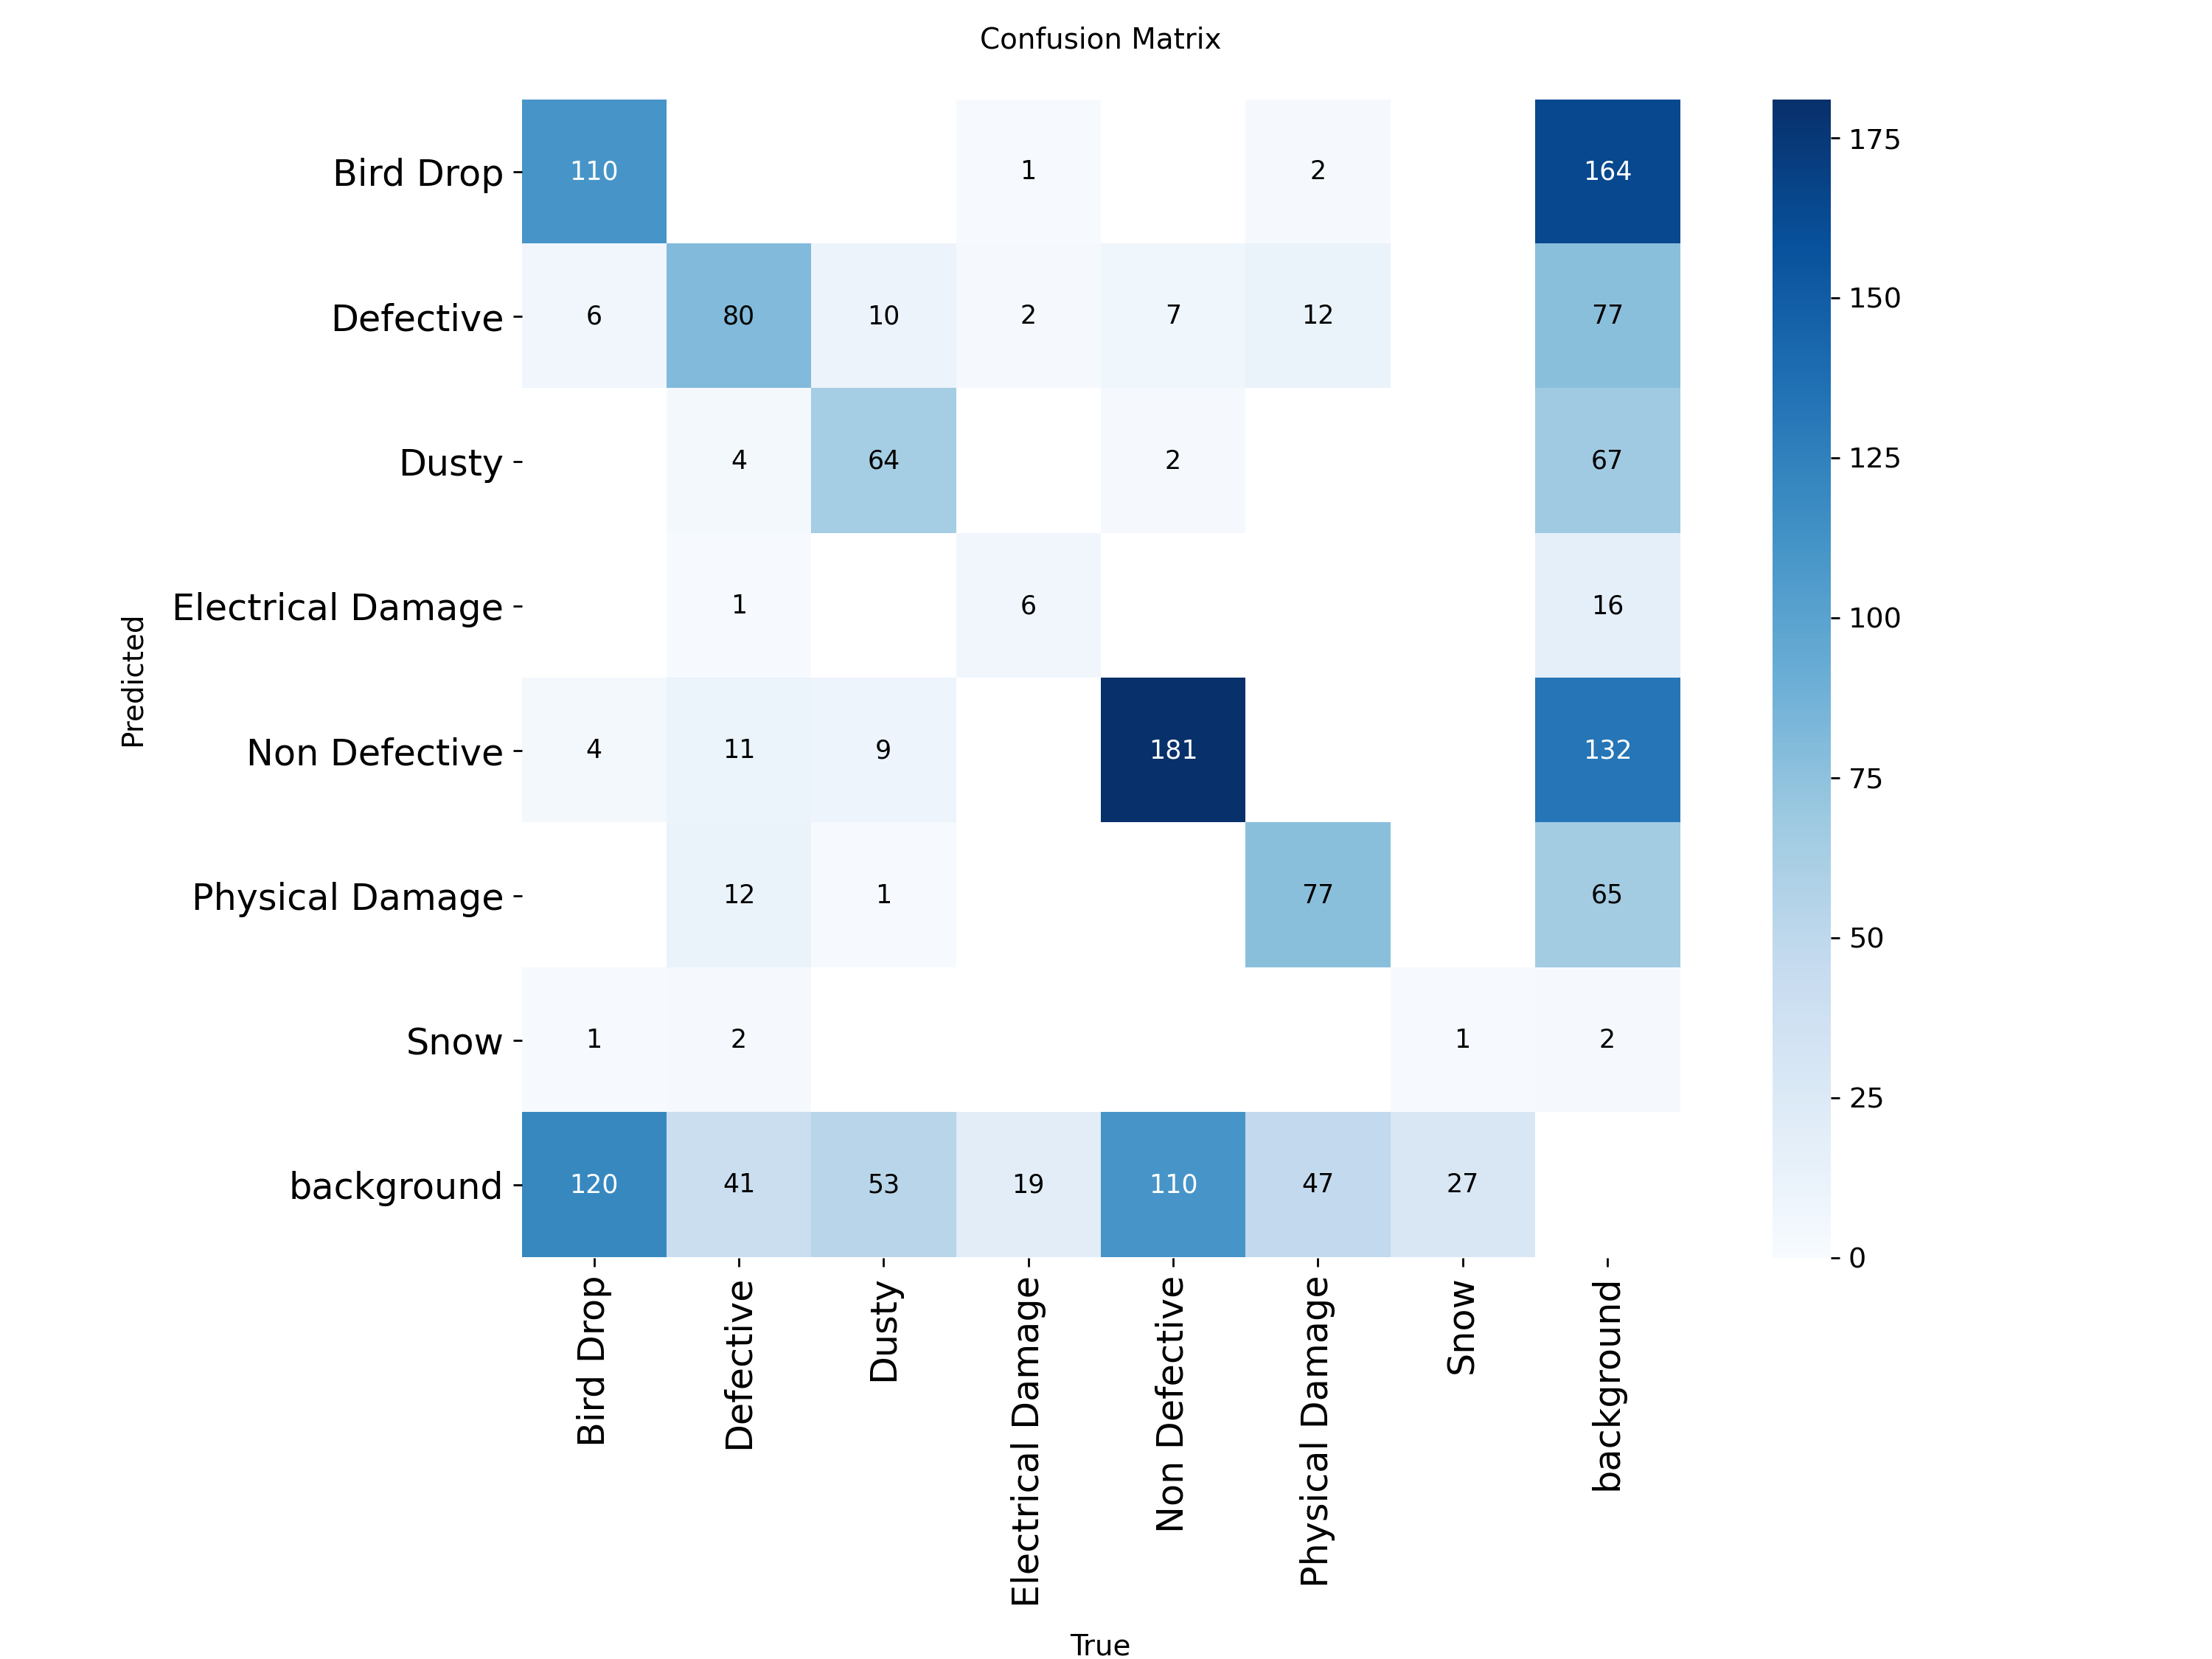


2. Training Graphs (Losses & mAP over Epochs):


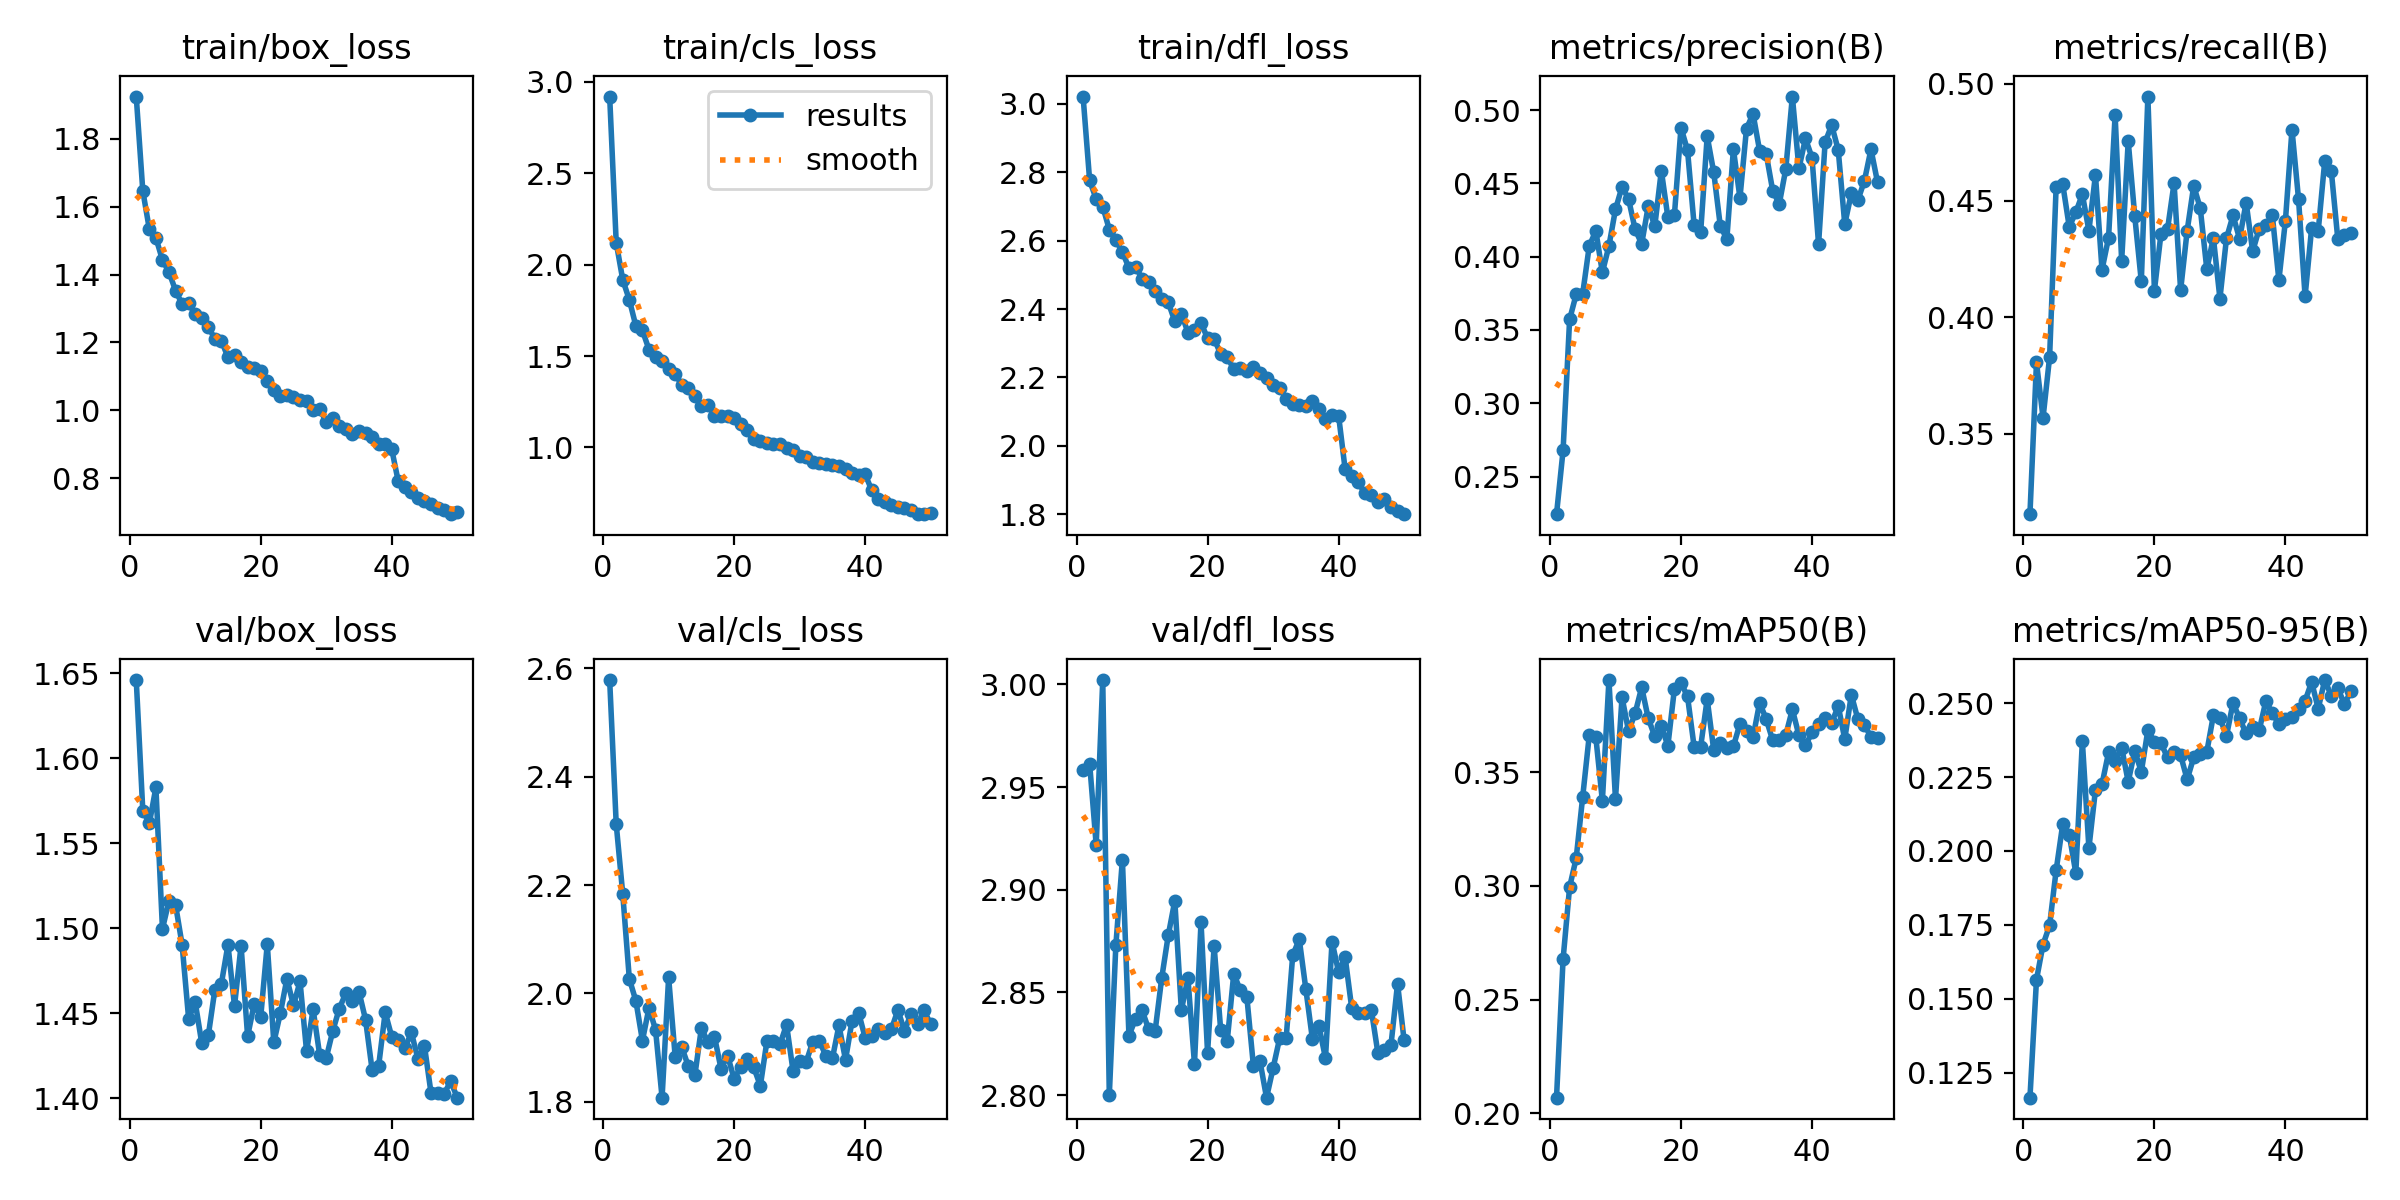


3. Precision-Recall Curve: File not found at /content/runs/obb/pv_fault_obb_high_acc/PR_curve.png

4. F1-Confidence Curve: File not found at /content/runs/obb/pv_fault_obb_high_acc/F1_curve.png

5. Precision-Confidence Curve: File not found at /content/runs/obb/pv_fault_obb_high_acc/P_curve.png

6. Recall-Confidence Curve: File not found at /content/runs/obb/pv_fault_obb_high_acc/R_curve.png


In [ ]:
from IPython.display import Image, display
import os
import glob
import time

# --- 1. CONFIGURATION ---
# The name of your high-accuracy run (MUST MATCH THE NAME USED IN CELL 3)
PROJECT_NAME = 'pv_fault_obb_high_acc'

# Path to the directory where all results are stored
RUNS_DIR = f'/content/runs/obb/{PROJECT_NAME}'

# --- 2. LIST OF PLOTS TO DISPLAY ---
plot_files = {
    "1. Confusion Matrix": 'confusion_matrix.png',
    "2. Training Graphs (Losses & mAP over Epochs)": 'results.png',
    "3. Precision-Recall Curve": 'PR_curve.png',
    "4. F1-Confidence Curve": 'F1_curve.png',
    "5. Precision-Confidence Curve": 'P_curve.png',
    "6. Recall-Confidence Curve": 'R_curve.png'
}

# --- 3. DISPLAY CODE ---
print(f"--- Visualizing All Results for Project: {PROJECT_NAME} ---")

if not os.path.exists(RUNS_DIR):
    print(f"\n!! ERROR: Run directory not found at {RUNS_DIR}")
    print("!! ACTION: Ensure the High Accuracy Training (Cell 3) was executed successfully and that the PROJECT_NAME matches.")
else:
    for title, filename in plot_files.items():
        file_path = os.path.join(RUNS_DIR, filename)

        # Check if the file exists before attempting to display
        if os.path.exists(file_path):
            print(f"\n{title}:")
            # Display the saved image file
            display(Image(filename=file_path, width=800))
        else:
            print(f"\n{title}: File not found at {file_path}")